<a href="https://colab.research.google.com/github/Dpanov2302/feedback-analysis/blob/main/text_classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Настройка среды и установка зависимостей

In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [ ]:
#Установить, после чего закомментить и перезапустить сеанс
#(нужно для TrainingArguments)

# !pip install transformers[torch]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2) Загрузка и подготовка данных

In [ ]:
df_org= pd.read_csv('/content/drive/MyDrive/ColabFiles/Archive/dataset.csv')

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,text,label
3114,Курсы по дизайну мобильных приложений стали дл...,positive
4001,"Проходила обучение на курсе""Финансовый аналити...",positive
1569,Преподаватели отзывчивые. Хорошее объяснение м...,positive
764,Проходила курс по профессии Веб-разработчик с ...,positive
7573,"Школа классная, единтсвенное неудобное это то ...",positive


In [ ]:
# df_org2 = pd.read_csv('/content/drive/MyDrive/ColabFiles/reviews.csv')

# df_org2 = df_org2.sample(frac=1.0, random_state=42)
# df_org2 = df_org2.rename(columns={"content": "text"})


# def delete_special_symbols(text):
#   text = text.replace('<br />', ' ').replace('\n', ' ')
#   return text

# df_org2['text'] = df_org2['text'].apply(delete_special_symbols)

# df_org2.head()

In [ ]:
# print(df_org.shape)
# print(df_org2.shape)

# df_org = pd.concat([df_org, df_org2])

# print(df_org.shape)

In [ ]:
labels = df_org['label'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['positive', 'negative']

In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'positive': 0, 'negative': 1}

In [ ]:
id2label

{0: 'positive', 1: 'negative'}

In [ ]:
df_org["label"]=df_org.label.map(lambda x: label2id[x.strip()])
df_org.head()

,text,label
3114,Курсы по дизайну мобильных приложений стали дл...,0
4001,"Проходила обучение на курсе""Финансовый аналити...",0
1569,Преподаватели отзывчивые. Хорошее объяснение м...,0
764,Проходила курс по профессии Веб-разработчик с ...,0
7573,"Школа классная, единтсвенное неудобное это то ...",0


<Axes: ylabel='count'>

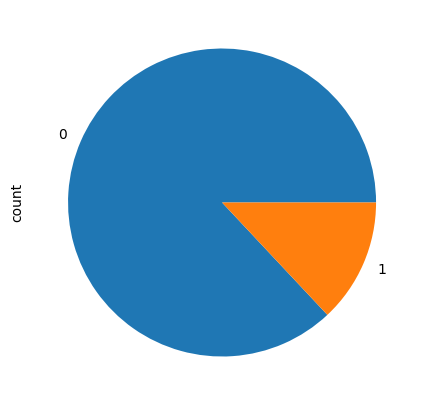

In [ ]:
df_org.label.value_counts().plot(kind='pie', figsize=(5,5))

### Лемматизация и удаление стоп-слов

In [ ]:
from pymystem3 import Mystem

mystem = Mystem()

def lemmatize_text(text):
    lemmatized_words = mystem.lemmatize(text)
    lemmatized_text = ' '.join([word for word in lemmatized_words if word.isalpha()])
    return lemmatized_text

df_org['text'] = df_org['text'].apply(lemmatize_text)

df_org.head()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


,text,label
3114,курсы по дизайн мобильный приложение становить...,0
4001,проходить обучение на курс финансовый аналитик...,0
1569,преподаватель отзывчивый хороший объяснение ма...,0
764,проходить курс по профессия веб разработчик с ...,0
7573,школа классный единтсвенный неудобный это то ч...,0


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('russian'))

def delete_stop_words(text):
  filtered_sentence = []
  word_tokens = word_tokenize(text)
  for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
  return ' '.join(filtered_sentence)

df_org['text'] = df_org['text'].apply(delete_stop_words)

df_org.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,label
3114,курсы дизайн мобильный приложение становиться ...,0
4001,проходить обучение курс финансовый аналитик об...,0
1569,преподаватель отзывчивый хороший объяснение ма...,0
764,проходить курс профессия веб разработчик ноль ...,0
7573,школа классный единтсвенный неудобный это учит...,0


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ColabFiles/Archive/dataset.csv')

df_org = data.rename(columns={'object': 'label'}).drop(columns='Unnamed: 0')

labels = data['object'].unique().tolist()
NUM_LABELS= len(labels)

id2label = {x: str(x) for x in labels}
label2id = {str(x): x for x in labels}


df_org.head()

,text,label
0,елена работать с наш девочка двойняшка на тот ...,2
1,с помощь роман мы с тройка сдавать егэ на балл...,2
2,не искать работа,2
3,дочь в класс заниматься с анастасия русский по...,2
4,основа программирование чипи чипь лувиви ламал...,2


## 3) Загрузка pre-trained модели SBERT для классификации текстов

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("ai-forever/sbert_large_nlu_ru", max_length=512)

model = BertForSequenceClassification.from_pretrained("ai-forever/sbert_large_nlu_ru", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

## 4) Загрузка данных в модель

In [ ]:
from sklearn.model_selection import train_test_split

SIZE= df_org.shape[0]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(list(df_org['text']),
                                                                  list(df_org['label']),
                                                                  test_size=0.25,
                                                                  shuffle=True,
                                                                  random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts,
                                                                  temp_labels,
                                                                  test_size=0.5,
                                                                  shuffle=False,
                                                                  random_state=42)

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(7359, 1226, 1227)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64, add_special_tokens = True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True, max_length=64, add_special_tokens = True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64, add_special_tokens = True)

In [ ]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## 5) Обучение и валидация

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/content/drive/MyDrive/ColabFiles/SBERT_checkpoints',
    do_train=True,
    do_eval=True,
    # The number of epochs
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=10,
    weight_decay=0.01,
    logging_strategy='steps',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=5,
    evaluation_strategy="steps",
    eval_steps=5,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
5,0.005400,0.002593,1.000000,1.000000,1.000000,1.000000
10,0.018300,0.004328,1.000000,1.000000,1.000000,1.000000
15,0.035000,0.025748,1.000000,1.000000,1.000000,1.000000
20,0.007500,0.000851,1.000000,1.000000,1.000000,1.000000
25,0.002700,0.000693,1.000000,1.000000,1.000000,1.000000
30,0.079500,0.000358,1.000000,1.000000,1.000000,1.000000
35,0.000700,0.000415,1.000000,1.000000,1.000000,1.000000
40,0.036600,0.065026,0.972222,0.930159,0.916667,0.958333
45,0.002500,0.000250,1.000000,1.000000,1.000000,1.000000
50,0.000500,0.000246,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=70, training_loss=0.013570672133937478, metrics={'train_runtime': 24.9604, 'train_samples_per_second': 43.869, 'train_steps_per_second': 2.804, 'total_flos': 127558536347520.0, 'train_loss': 0.013570672133937478, 'epoch': 5.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.000205,1.0,1.0,1.0,1.0
val,0.000206,1.0,1.0,1.0,1.0
test,0.000180,1.0,1.0,1.0,1.0


In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
# Test with a an example text in Russian
text = "{Ужасный курс! Злые и жадные преподаватели, логика отсутствует напрочь.}."

predict(text)

(tensor([[0.0025, 0.0026, 0.9949]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(2, device='cuda:0'),
 '2')

### Сохранение модели

In [ ]:
model_path = "/content/drive/MyDrive/saved_models/sbert-object-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/saved_models/sbert-object-classification-model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_models/sbert-object-classification-model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_models/sbert-object-classification-model/vocab.txt',
 '/content/drive/MyDrive/saved_models/sbert-object-classification-model/added_tokens.json',
 '/content/drive/MyDrive/saved_models/sbert-object-classification-model/tokenizer.json')

### Загрузка модели

In [ ]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast

model_path = '/content/drive/MyDrive/saved_models/sbert-text-classification-model'

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
# Пример
nlp("Я не понял эту тему")

[{'label': 'positive', 'score': 0.830734372138977}]

In [ ]:
label2id = {'positive': 1, 'negative': 0}

In [ ]:
data = pd.read_csv('/content/test_data.csv')
data.head()

,hash,timestamp,question_1,question_2,question_3,question_4,question_5
0,6758859381752519691,2024-04-22 19:03:00,Новейшие тенденции в IT,Преподователь ел носки,Носки,пикапика,чипи-чипи
1,-5134118675246852169,2024-04-03 18:00:00,Основы программирования,Лекционный материал был очень структурирован и...,"Да, объяснения по массивам и их методам были с...",Предложить дополнительные учебные видео по сло...,Введение в объектно-ориентированное программир...
2,-968268261123424087,2024-04-06 14:00:00,Продвинутые техники программирования,Очень понравился глубокий разбор алгоритмов со...,"Нет, все было понятно.",Организовать больше интерактивных сессий для о...,Алгоритмы оптимизации.
3,4896484430320162846,2024-04-08 16:00:00,Новейшие тенденции в IT,Презентация кейсов из реальной жизни помогла п...,"Да, тема криптовалют осталась не до конца поня...",Увеличить время на вопросы и ответы в конце ка...,Использование блокчейн технологий в различных ...
4,4354272097770242871,2024-04-11 15:00:00,Основы программирования,Разбор базового синтаксиса Python был особенно...,Нет.,Включить больше примеров кода в презентации дл...,Библиотеки Python для анализа данных.


In [ ]:
data['text'] = data['question_2'] + ' ' + data['question_3'] + ' ' + data['question_4']
data.columns

Index(['hash', 'timestamp', 'question_1', 'question_2', 'question_3',
       'question_4', 'question_5', 'text'],
      dtype='object')

In [ ]:
is_positive = []
for i, text in enumerate(data['text']):
    res = label2id[nlp(text)[0]['label']]
    print(i, res)
    is_positive.append(res)

0 0
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 0
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 0
22 1
23 0
24 0
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 0
35 1
36 0
37 0
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 0
51 1
52 1


In [ ]:
is_positive

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1]

In [ ]:
sub = pd.read_csv('/content/sample_submission.csv')
sub.head()

,hash,is_relevant,object,is_positive
0,6758859381752519691,1,2,1
1,-5134118675246852169,1,0,1
2,-968268261123424087,1,0,1
3,4896484430320162846,1,1,1
4,4354272097770242871,1,0,1


In [ ]:
is_positive = pd.Series(is_positive)

In [ ]:
sub['is_positive'] = is_positive

In [ ]:
sub.head()

,hash,is_relevant,object,is_positive
0,6758859381752519691,1,2,0
1,-5134118675246852169,1,0,1
2,-968268261123424087,1,0,1
3,4896484430320162846,1,1,1
4,4354272097770242871,1,0,1


In [ ]:
sub.to_csv('/content/sample_submission.csv')